In [119]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [121]:
images = []
ages = []
genders = []

for i in os.listdir('../input/utkface-new/crop_part1/')[0:8000]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open('../input/utkface-new/crop_part1/' + i))

In [122]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images, ages, genders], axis=1)

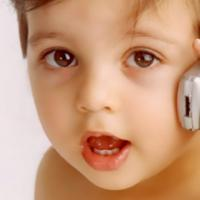

2 0


In [123]:
display(df['Images'][43])
print(df['Ages'][43], df['Genders'][43])

## some graphs

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


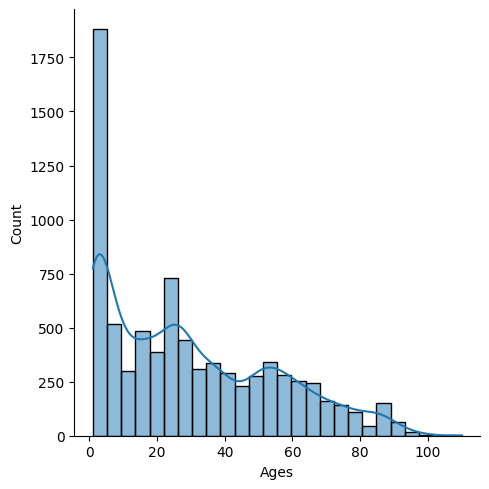

In [124]:
sns.displot(df['Ages'], kde = True)

<Axes: xlabel='Genders'>

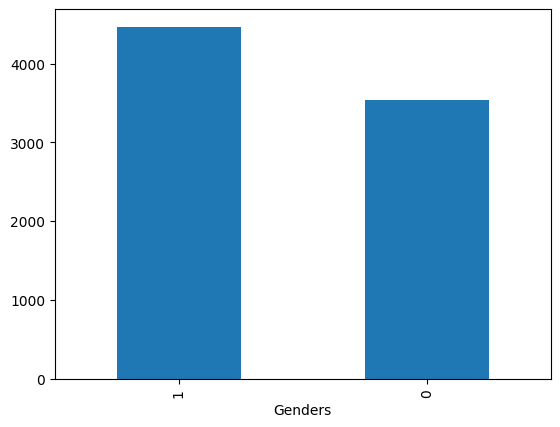

In [125]:
df['Genders'].value_counts().plot(kind = 'bar')

In [126]:
under4s = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['Ages'] > 4]

df = pd.concat([df, under4s], ignore_index = True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


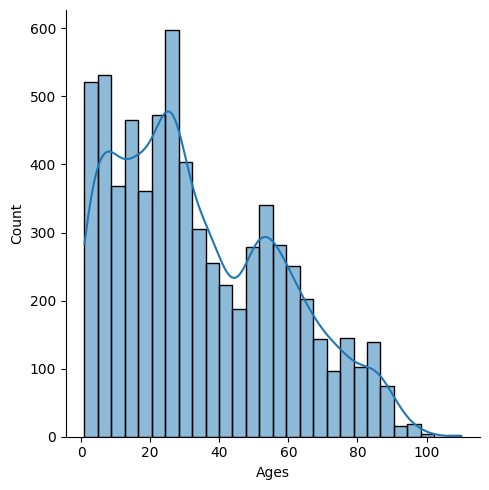

In [127]:
sns.displot(df['Ages'], kde = True)

In [128]:
df.loc[df['Ages'] > 80, 'Ages'] = 81

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


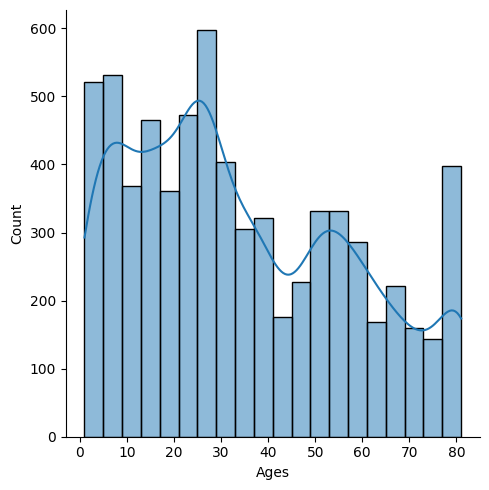

In [129]:
sns.displot(df['Ages'], kde = True)

In [130]:
df['Genders'].value_counts()

Genders
1    3838
0    2946
Name: count, dtype: int64

In [166]:
import numpy as np
from PIL import Image

# Initialize lists to store the processed data
x = []
y = []

# Use .loc to avoid the warning
for i in range(len(df)):
    # Get the image from the DataFrame
    img = df.loc[i, 'Images']
    
    # Resize the image
    img_resized = img.resize((100, 100), Image.ANTIALIAS)
    
    # Convert the image to a numpy array
    ar = np.asarray(img_resized)
    
    # Append the numpy array to the list
    x.append(ar)
    
    # Get the age and gender and append them to the list
    agegen = [int(df.loc[i, 'Ages']), int(df.loc[i, 'Genders'])]
    y.append(agegen)

# Convert lists to numpy arrays
x = np.array(x)
y = np.array(y)


In [167]:
y_age = df['Ages']
y_gender = df['Genders']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)

In [170]:
agemodel = Sequential()
agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((3,3)))
agemodel.add(Flatten())
agemodel.add(Dense(64, activation='relu'))
agemodel.add(Dropout(0.5))
agemodel.add(Dense(1, activation='relu'))

agemodel.compile(loss='mean_squared_error',
             optimizer=optimizers.Adam(learning_rate=0.001))

genmodel = Sequential()
genmodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(64, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(128, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((3,3)))
genmodel.add(Flatten())
genmodel.add(Dense(64, activation='relu'))
genmodel.add(Dropout(0.5))
genmodel.add(Dense(1, activation='sigmoid'))

genmodel.compile(loss='binary_crossentropy',
             optimizer=optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

# training

In [171]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train1 = datagen.flow(x_train_age, y_train_age, batch_size=32)

test1 = test_datagen.flow(
        x_test_age, y_test_age,
        batch_size=32)

history1 = agemodel.fit(train1, epochs=50, shuffle=True, validation_data=test1)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


170/170 ━━━━━━━━━━━━━━━━━━━━ 61s 344ms/step - loss: 880.2570 - val_loss: 560.9918
Epoch 2/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 59s 343ms/step - loss: 624.1894 - val_loss: 547.7317
Epoch 3/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 345ms/step - loss: 581.1491 - val_loss: 506.5815
Epoch 4/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 83s 349ms/step - loss: 547.9127 - val_loss: 453.9134
Epoch 5/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 81s 343ms/step - loss: 456.3585 - val_loss: 349.8603
Epoch 6/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 59s 343ms/step - loss: 418.9646 - val_loss: 321.5812
Epoch 7/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 82s 342ms/step - loss: 402.6832 - val_loss: 278.8519
Epoch 8/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 58s 339ms/step - loss: 354.2610 - val_loss: 264.6286
Epoch 9/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 83s 343ms/step - loss: 348.1795 - val_loss: 255.6606
Epoch 10/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 59s 343ms/step - loss: 329.2322 - val_loss: 257.3965
Epoch 11/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 58s 339ms/step - loss: 315.3246 - val_l

In [172]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_gender, y_train_gender, batch_size=64)

test2 = test_datagen.flow(
        x_test_gender, y_test_gender,
        batch_size=64)

history2 = genmodel.fit(train2, epochs=50, shuffle=True, validation_data=test2)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 66s 743ms/step - accuracy: 0.5716 - loss: 0.6699 - val_accuracy: 0.7214 - val_loss: 0.5432
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 71s 822ms/step - accuracy: 0.7284 - loss: 0.5493 - val_accuracy: 0.7472 - val_loss: 0.5288
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 77s 760ms/step - accuracy: 0.7265 - loss: 0.5516 - val_accuracy: 0.7730 - val_loss: 0.4780
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 63s 730ms/step - accuracy: 0.7436 - loss: 0.5376 - val_accuracy: 0.7870 - val_loss: 0.4703
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 63s 732ms/step - accuracy: 0.7574 - loss: 0.5020 - val_accuracy: 0.7996 - val_loss: 0.4364
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 63s 728ms/step - accuracy: 0.7694 - loss: 0.4723 - val_accuracy: 0.8099 - val_loss: 0.4150
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 63s 729ms/step - accuracy: 0.7830 - loss: 0.4670 - val_accuracy: 0.8150 - val_loss: 0.4038
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 64s 734ms/step - accuracy: 0.7805 - loss: 0.4519 - val_accu

In [191]:
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((100,100), Image.ANTIALIAS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((100,100), Image.ANTIALIAS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((100,100), Image.ANTIALIAS)
            
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 100, 100, 3)
    
    age = agemodel.predict(ar)
    gender = np.round(genmodel.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'
        
    print('Age:', int(age), '\n Gender:', gender)
    return im.resize((300,300), Image.ANTIALIAS)

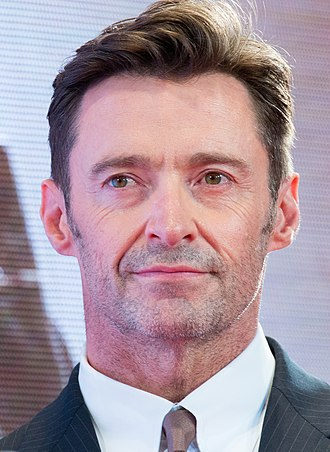

In [192]:
Image.open('/kaggle/input/hughjackman/test.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Age: 35 
 Gender: female


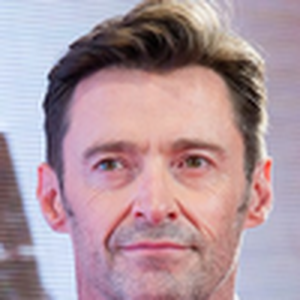

In [195]:
process_and_predict('/kaggle/input/hughjackman/test.jpg')
